In [1]:
from IPython.display import HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
import scipy.spatial

import sys
sys.path.append("..")
from sportvu.sportvu_helper import *

%matplotlib inline

## Defensive Tracking

This notebook is a replication of the 2nd half of https://mc-stan.org/users/documentation/case-studies/bball-hmm.html

In [2]:
game = load_game_data("0021500001")

## Event Keys

### EVENTMSGTYPE
1 - Make <br>
2 - Miss <br>
3 - Free Throw <br>
4 - Rebound <br>
5 - out of bounds / Turnover / Steal <br>
6 - Personal Foul <br>
7 - Violation <br>
8 - Substitution <br>
9 - Timeout <br>
10 - Jumpball <br>
12 - Start Q1? <br>
13 - Start Q2?<br>

### EVENTMSGACTIONTYPE
1 - Jumpshot <br>
2 - Lost ball Turnover <br>
3 - ? <br>
4 - Traveling Turnover / Off Foul <br>
5 - Layup <br>
7 - Dunk <br>
10 - Free throw 1-1 <br>
11 - Free throw 1-2 <br>
12 - Free throw 2-2 <br>
40 - out of bounds <br>
41 - Block/Steal <br>
42 - Driving Layup <br>
50 - Running Dunk <br>
52 - Alley Oop Dunk <br>
55 - Hook Shot <br>
57 - Driving Hook Shot <br>
58 - Turnaround hook shot <br>
66 - Jump Bank Shot <br>
71 - Finger Roll Layup <br>
72 - Putback Layup <br>
108 - Cutting Dunk Shot <br>

# Defensive Tracking as found in



In [3]:
import pystan

In [4]:
event_id = 215
play = game.tracking_data[game.tracking_data['event_id'] == event_id]
times = play['game_clock'].unique()
team_a, team_b = game.tracking_data[game.tracking_data['event_id'] == 1]['team_id'].unique()[1:]
ball_pos = []
off_pos = []
def_pos = []
for t in times:
    f = play[play['game_clock'] == t]
    if len(f) == 11:
        bp = f[f['team_id'] == -1][['x_loc','y_loc']].values
        op = f[f['team_id'] == team_a][['x_loc', 'y_loc']].values
        dp = f[f['team_id'] == team_b][['x_loc', 'y_loc']].values
        ball_pos.append(bp)
        off_pos.append(op.flatten())
        def_pos.append(dp.flatten())
ball_pos = np.vstack(ball_pos)
off_pos = np.vstack(off_pos)
def_pos = np.vstack(def_pos)

In [5]:
hmm_model_code = """
data {
  int<lower=0> N; // # of observations
  int<lower=0> K; // # of states
  int<lower=0> D;
  vector[D] ball_positions[N];
  vector[D * K] offense_positions[N];
  vector[D * K] defense_positions[N];
  vector[D] hoop_position;
}

transformed data {
    vector[3] lambda_alpha = [6,6,6]';
    vector[5] theta_alpha = [6,6,6,6,6]';
}

parameters {
  simplex[K] theta[K]; // State transition matrix
  simplex[3] lambda; // weights of convex combinations
  //positive_ordered[2] mu[K]; // Observation distributions
}

transformed parameters {
    
    vector[D * K] mu[N];
    for(i in 1:N) {
        vector[D] val;
        val = lambda[1] * ball_positions[i] + lambda[2] * hoop_position;
        for(j in 1:K) {
            mu[i][j * D - 1:j * D] = val + lambda[3] * offense_positions[i][j * D - 1: j * D];
        }
    }
}

model {
  // priors
  //mu[1] ~ normal(-5, 2); // Prior over observation mean for "low state"
  //mu[2] ~ normal(-10, 2); // Prior over observation mean for "high state"
  
  lambda ~ dirichlet(lambda_alpha);
  for(i in 1:K) {
      theta[i] ~ dirichlet(theta_alpha);
  }
  
  
  // computing the likelihood via. the forward algorithm
  {
      // iterating over each individual player
      for(i in 1:K) {
          real acc[K];
          real gamma[N, K];
          for (k in 1:K)
            gamma[1, k] = normal_lpdf(defense_positions[1,i * D - 1 : i * D] | mu[1][k * D - 1 : k * D], 2); // Observation model dependent
          for (t in 2:N) {
            for (k in 1:K) {
              for (j in 1:K)
                acc[j] = gamma[t-1, j] + log(theta[j, k]) + normal_lpdf(defense_positions[t,i * D - 1 : i * D] | mu[t][k * D - 1 : k * D], 2); // Observation model dependent
              gamma[t, k] = log_sum_exp(acc);
            }
          }
          target += log_sum_exp(gamma[N]);
      }
  }
}

generated quantities {
    int<lower=1,upper=K> z_star[N, K];
    
    // viterbi algorithm to estimate the optimal state sequence given the observations
    for(i in 1:K) { // iterate over every defenseive player
        real log_p_z_star;
        {
            int back_ptr[N, K];
            real best_logp[N, K];
            for (k in 1:K)
              best_logp[1, k] = normal_lpdf(defense_positions[1,i * D - 1 : i * D] | mu[1][k * D - 1 : k * D], 2);
            for (t in 2:N) {
              for (k in 1:K) {
                best_logp[t, k] = negative_infinity();
                for (j in 1:K) {
                  real logp;
                  logp = best_logp[t-1, j] + log(theta[j, k]) + normal_lpdf(defense_positions[t,i * D - 1 : i * D] | mu[t][k * D - 1 : k * D], 2);
                  if (logp > best_logp[t, k]) {
                    back_ptr[t, k] = j;
                    best_logp[t, k] = logp;
                  }
                }
              }
        }
        log_p_z_star = max(best_logp[N]);
        for (k in 1:K)
          if (best_logp[N, k] == log_p_z_star)
            z_star[N,i] = k;
        for (t in 1:(N - 1))
          z_star[N - t,i] = back_ptr[N - t + 1, z_star[N - t + 1,i]];
        }
    }
}
"""
hmm_model = pystan.StanModel(model_code = hmm_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a474f8f8301655d657d532e41b2cc77c NOW.


In [6]:
data = {
    'N' : ball_pos.shape[0],
    'K' : 5,
    'D' : 2,
    'ball_positions' : ball_pos,
    'offense_positions' : off_pos,
    'defense_positions' : def_pos,
    'hoop_position' : np.array([0,25.])
}
fit = hmm_model.sampling(data = data, iter = 100, chains = 1)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [7]:
z_star = fit.extract()['z_star'].astype(int)
mfs = []
for k in range(5):
    mf = []
    for i in range(z_star.shape[1]):
        mf.append(np.bincount(z_star[:,i,k]).argmax())
    mfs.append(mf)

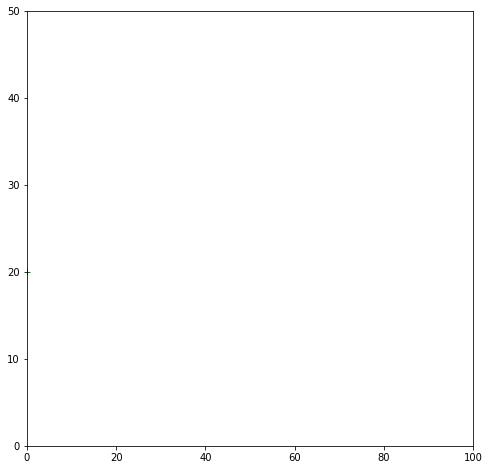

In [8]:
fig, ax = plt.subplots()

offense_positions, = ax.plot([],[], marker = 'o', linestyle = 'None', color = 'b')
ball_position, = ax.plot([],[], marker = 'o', linestyle = 'None', color = 'orange')
defense_positions, = ax.plot([],[], marker = 'x', linestyle = 'None', color = 'r')
lines = []
for i in range(5):
    line, = ax.plot([],[], color = 'black')
    lines.append(line)
    
hoop_position, = ax.plot(0, 20, marker = '+', color = 'g', linestyle = 'None')
ax.set_xlim([0,100])
ax.set_ylim([0,50])
def init():
    offense_positions.set_data([], [])
    ball_position.set_data([], [])
    defense_positions.set_data([],[])
    hoop_position.set_data(0,20)
    for i in range(len(lines)):
        lines[i].set_data([],[])
    return offense_positions, ball_position, defense_positions, hoop_position, (*lines),

def animate(i):
    #for i in range(off_pos.shape[0]):
    off_pos_z = off_pos[i,:].reshape(5,2)
    def_pos_z = def_pos[i,:].reshape(5,2)
    ball_pos_z = ball_pos[i,:]
    
    ball_position.set_data(ball_pos_z[0], ball_pos_z[1])
    ball_position.set_markersize(6)
    offense_positions.set_data(off_pos_z[:,0], off_pos_z[:,1])
    offense_positions.set_markersize(12)
    
    defense_positions.set_data(def_pos_z[:,0], def_pos_z[:,1])
    defense_positions.set_markersize(12)
    
    for k in range(len(lines)):
        lines[k].set_data([def_pos_z[k,0],off_pos_z[mfs[k][i] - 1,0]], [def_pos_z[k,1],off_pos_z[mfs[k][i] - 1,1]])
    
    hoop_position.set_data(0, 20)
    hoop_position.set_markersize(6)
    
    return ball_position, offense_positions, defense_positions, (*lines),


ani = animation.FuncAnimation(fig, animate, frames = len(mfs[0]), interval = 25, blit = True, init_func = init)
fig.set_size_inches(8,8)

In [9]:
HTML(ani.to_html5_video())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '576x576', '-pix_fmt', 'rgba', '-r', '40.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmp0hnufraw/temp.m4v']
